$\def \dot #1#2{\left\langle #1, #2 \right\rangle}$
$\def \adot #1#2{\left\langle #1, #2 \right\rangle}$
$\def \cD {\mathcal{D}}$
$\def \cY {\mathcal{Y}}$
$\def \cM {\mathcal{M}}$
$\def \bc {\mathbf{c}}$
$\def \bv {\mathbf{v}}$
$\def \bG {\mathbf{G}}$
$\newcommand{\rd}{\mathop{}\!\mathrm{d}}$

# Residual minimization for state estimation

## This worksheet mostly contains test for a publication

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Latex, display

import sys
sys.path.append("../../")
import pyhilbert as hil
import pyredmod as rm

import os.path
from labellines import *
sns.set_style("whitegrid")
cp = sns.color_palette()

%matplotlib inline

In [7]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {return false;}

<IPython.core.display.Javascript object>

# Lets test the alternating minimization

This scheme involves alternately finding $y^*_n$, our best guess for the parameters, and $v^*_n$, the nearest point that satisfies the data that is closest to $u(y^*_n)$ in the sense of the residual.

The idea comes from the observation that
$$
\begin{aligned}
\| u^* - u(y) \|_V 
&\sim \| \mathrm{div} (a(y) \nabla (u^* - u(y))) \|_{V'} \\
&= \| \mathrm{div} (a(y) \nabla u^*) + f \|_{V'} \\
\end{aligned}
$$

So now we want to minimise this last expression, or find succesive
$$
\begin{aligned}
y^*_{n+1} &= \arg\min_{y \in \cY} \| \mathrm{div} (a(y) \nabla u^*_n) + f \|_{V'} \\
u^*_{n+1} &= \arg\min_{P_W u = w} \| \mathrm{div} (a(y^*_{n+1}) \nabla u) + f \|_{V'}
\end{aligned}
$$

We take our field $a(y)$ to be of the form $a(y) = \bar a + \sum_{j=1}^d y_j \, \psi_j$

As described we can find   $y^*_n$ through the following
$$
y^*_{n+1} = \begin{aligned} \label{eq:min}
{\arg \min}_{y\in \cY} \left\| \mathrm{div} (\bar a \nabla u^*_n)  + f + \sum_{i=1}^d y_i \mathrm{div}(\psi_i \nabla u^*_n) \right\|_{V'}^2
= {\arg \min}_{y\in \cY} \left\| \phi_0 + \sum_{i=1}^d y_i \phi_j \right\|_{V}^2
\end{aligned}
$$

where now the $\phi_j \in V$ are the representers of $\mathrm{div}(\psi_i \nabla u^*_n)$ and $\phi_0$ of $\mathrm{div} (\bar a \nabla u^*_n) + f$. We calculate this explicitly through the usual Galerkin projection:

$$
\int \nabla \phi_0 \cdot \nabla v \rd x = \int f v \rd x + \int \bar a \nabla u^*_n \cdot \nabla v \rd x
$$
and
$$
\int \nabla \phi_j \cdot \nabla v \rd x = \int \psi_j \nabla u^*_n \cdot \nabla v \rd x
$$

Then the solution to the minimisation problem is a linear system

In [8]:
def make_soln(points, field_space, fem_space, a_bar=1.0, c=0.5, f=1.0, verbose=False):
    
    solns = hil.Basis(np.zeros((H1_fine.n, len(points))), space=H1_fine)
    fields = []
    
    for i, p in enumerate(np.atleast_2d(points)):
        field = hil.Vector(a_bar + c * p, space=field_space)
        fields.append(field)
        # Then the fem solver (there a faster way to do this all at once? This will be huge...
        fem_solver = hil.DyadicFEMSolver(fem_space = fem_space, rand_field = field, f = 1)
        fem_solver.solve()
        solns._values[:,i] = fem_solver.u.values
        
    return solns, fields

def alternate_minimize(u_0, w_coords, Wm, Wm_L2, u, y, pde, y_guesser, n_steps=20):
    
    w = Wm.dot_to_projection(w_coords)
    
    u_star_n = None
    y_star_n = None
    v_star_n = u_0
    
    u_star_err = np.zeros(n_steps)
    v_star_err = np.zeros(n_steps)
    y_err = np.zeros(n_steps)
    y_resids = np.zeros(n_steps)
    v_resids = np.zeros(n_steps)

    v_star_err[0] = (u - v_star_n).norm()
    u_star_err[0] = np.inf
    
    for i in range(1,n_steps):    
        # First the y guess is made from the projection
        y_star_n, y_resids[i] = y_guesser.nearest_params_resid(v_star_n)
        u_star_n = pde(np.atleast_2d(y_star_n))[0]

        v_star_n, v_resids[i] = y_guesser.nearest_resid(y_star_n, w, w_te, Wm_L2)

        v_star_err[i] = (u_te - v_star_n).norm()
        u_star_err[i] = (u_te - u_star_n).norm()
        y_err[i] = np.linalg.norm(y - y_star_n)

    return u_star_err, y_resids, v_star_err, v_resids, y_err

In [9]:
# Spirals!
def spiral_cw(A):
    A = np.array(A)
    out = []
    while(A.size):
        out.append(A[0])        # take first row
        A = A[1:].T[::-1]       # cut off first row and rotate counterclockwise
    return np.concatenate(out)

def spiral_ccw(A):
    A = np.array(A)
    out = []
    while(A.size):
        out.append(A[0][::-1])    # first row reversed
        A = A[1:][::-1].T         # cut off first row and rotate clockwise
    return np.concatenate(out)

def base_spiral(nrow, ncol):
    return spiral_ccw(np.arange(nrow*ncol).reshape(nrow,ncol))[::-1]

def to_spiral(A):
    A = np.array(A)
    B = np.empty_like(A)
    B.flat[base_spiral(*A.shape)] = A.flat
    return B

In [10]:
fem_div = 7
H1_fine = hil.H1DyadicSq(fem_div)
a_bar = 1.0

width_div = 2
spacings = [5, 6]

Wms = []
Wms_L2 = []
Wms_loc = []
Wms_name = []
for spacing_div in spacings:
    Wm_reg, Wm_reg_L2, Wm_loc_reg = rm.make_local_avg_grid_basis(width_div, spacing_div, fem_div, return_map=True)
    Wms.append(Wm_reg)
    Wms_L2.append(Wm_reg_L2)
    Wms_loc.append(Wm_loc_reg)
    Wms_name.append(f'reg_{Wm_reg.n}')

ms = [4,8,16]
for m in ms:
    np.random.seed(2)
    Wm_rand, Wm_rand_L2, Wm_loc_rand = rm.make_local_avg_random_basis(m, fem_div, width=4, bounds=np.array([[0, 0.5], [0, 1]]), return_map=True)
    Wms.append(Wm_rand)
    Wms_L2.append(Wm_rand_L2)
    Wms_loc.append(Wm_loc_rand)
    Wms_name.append(f'rand_{Wm_rand.n}')

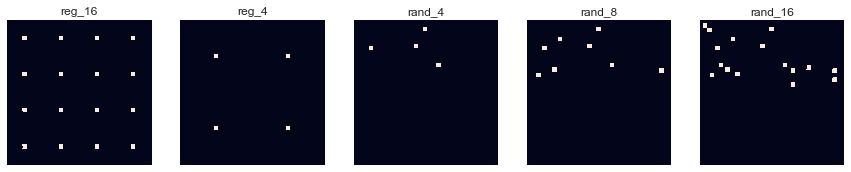

In [11]:
fig = plt.figure(figsize=(15, 7))
for i, Wm_loc in enumerate(Wms_loc):
    ax = fig.add_subplot(1, len(Wms_loc), i+1)
    sns.heatmap(Wm_loc, square=True, cbar=False, xticklabels=False, yticklabels=False)
    ax.set_title(Wms_name[i])
plt.show()

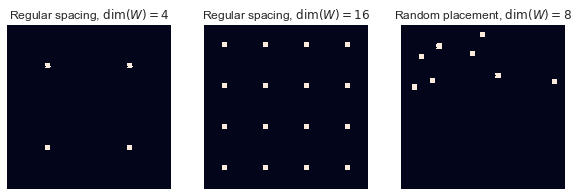

In [12]:
fig = plt.figure(figsize=(10, 8))
Wm_names = [rf'Regular spacing, $\mathrm{{dim}}(W) = 4$', rf'Regular spacing, $\mathrm{{dim}}(W) = 16$', rf'Random placement, $\mathrm{{dim}}(W) = 8$']
for i, Wm_loc in enumerate([Wms_loc[c_i] for c_i in [1,0,3]]):
    ax = fig.add_subplot(1, 3, i+1)
    sns.heatmap(Wm_loc, square=True, cbar=False, xticklabels=False, yticklabels=False)
    ax.set_title(Wm_names[i])

plt.savefig(f'./figs/meas_locs.pdf', bbox_inches='tight')
plt.show()

In [ ]:
N_tr = 2000
N_te = 10
cs = [0.5, 0.9, 0.99]
field_divs = [1,2]
spacings = [5, 6]

fem_div = 7
H1_fine = hil.H1DyadicSq(fem_div)
a_bar = 1.0 
field_conv = 1
n_steps = 20

# Indexes: 
# 1: Result type, 0 = u_star, 1 = v_star
# 2: Starting point, 0 = w, 1 = u_w
# 3: c
# 4: field_div
# 5: Wm choice
# 6: Test point
#errs = np.zeros((2,2,3,2,len(Wms),N_te,n_steps))
#res = np.zeros((2,2,3,2,len(Wms),N_te,n_steps))
for i, c in enumerate(cs):
    if i == 1:
        for j, field_div in enumerate(field_divs[1:2]):
            j = j+1
            #field_div = 2
            L2_coarse = hil.L2DyadicSq(field_div)
            #c = 0.9
            side_n = 2**field_div
            d = side_n * side_n
            y_range = np.zeros((d,2))
            y_range[:,0] = -1.0
            y_range[:,1] = 1.0

            index_spiral = to_spiral(np.arange(1,side_n**2+1).reshape((side_n, side_n)))
            weight = ((1 / index_spiral) ** field_conv).flatten()
            y_range = (y_range.T * weight).T

            def diffusion_pde(points):
                solns, fields = make_soln(points, field_space=L2_coarse, fem_space=H1_fine, a_bar=a_bar, c=c)
                return solns
            
            np.random.seed(1)
            points_tr = np.random.random((N_tr, d)) * (y_range[:, 1] - y_range[:, 0]) + y_range[:, 0]
            us_tr = diffusion_pde(points_tr)
            points_te = np.random.random((N_te, d)) * (y_range[:, 1] - y_range[:, 0]) + y_range[:, 0]
            us_te = diffusion_pde(points_te)

            u_mid = diffusion_pde(np.zeros((1,d)))[0]
            us_tr_mf = us_tr - u_mid

            y_guesser = hil.DyadicGuesser(field_mean=a_bar, field_mult=c, fem_space=H1_fine, field_space=L2_coarse, y_bounds=y_range)

            for k, (Wm, Wm_L2) in enumerate(zip(Wms, Wms_L2)):
                Wm_ortho = Wm.orthonormalise()
                m = Wm.n
                print(f'c: {c} d: {d} m: {m}')

                ws_te = Wm.A @ us_te
                ws_te_ortho = Wm_ortho.A @ us_te
                greedy = rm.GreedyApprox(us_tr_mf, verbose=True)

                Vn, resids, betas = greedy.construct_to_poor_mans_criteria(Wm)
                lin_est = rm.LinearWorstCaseEstimator(Vn.orthonormalise(), center=u_mid, Wm=Wm_ortho)
                u_stars = lin_est.best_estimate(ws_te_ortho)
                for l in range(N_te):
                    u_te = us_te[l]
                    y_te = points_te[l]
                    w_te = ws_te[:,l]
                    w_te_ortho = ws_te_ortho[:,l]
                    w = Wm.dot_to_projection(w_te)

                    # First we just use w as a starting point
                    errs[0,0,i,j,k,l,:], res[0,0,i,j,k,l,:], errs[1,0,i,j,k,l,:], res[1,0,i,j,k,l,:], = alternate_minimize(w, w_te, Wm, Wm_L2, u_te, y_te, diffusion_pde, y_guesser, n_steps)
                    # Now we use u*(w) as a starting point
                    errs[0,1,i,j,k,l,:], res[0,1,i,j,k,l,:], errs[1,1,i,j,k,l,:], res[1,1,i,j,k,l,:], = alternate_minimize(u_stars[l], w_te, Wm, Wm_L2, u_te, y_te, diffusion_pde, y_guesser, n_steps)

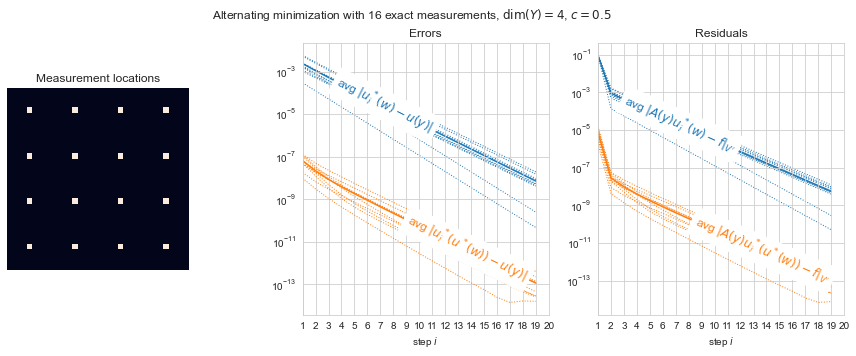

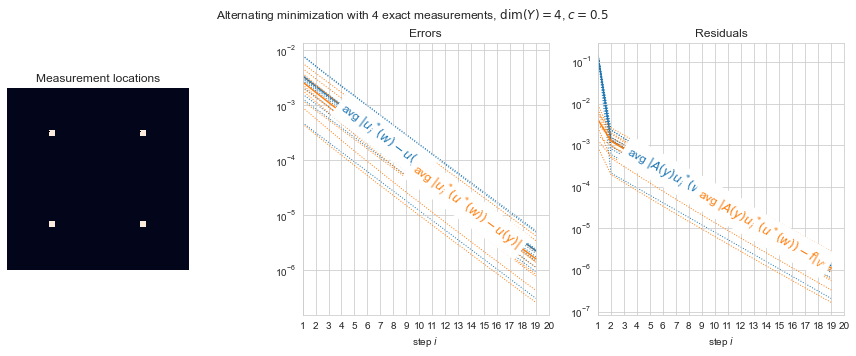

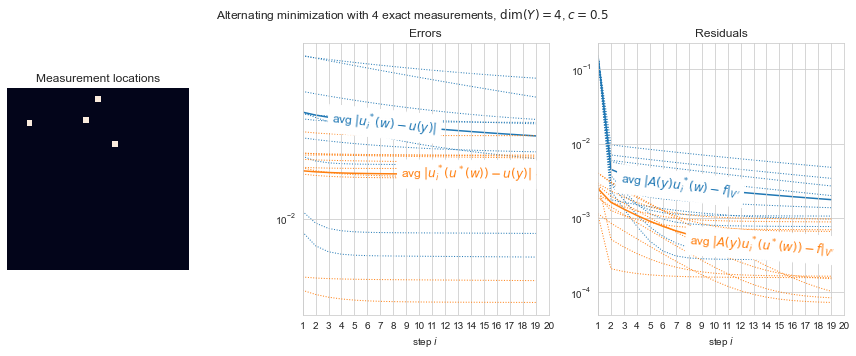

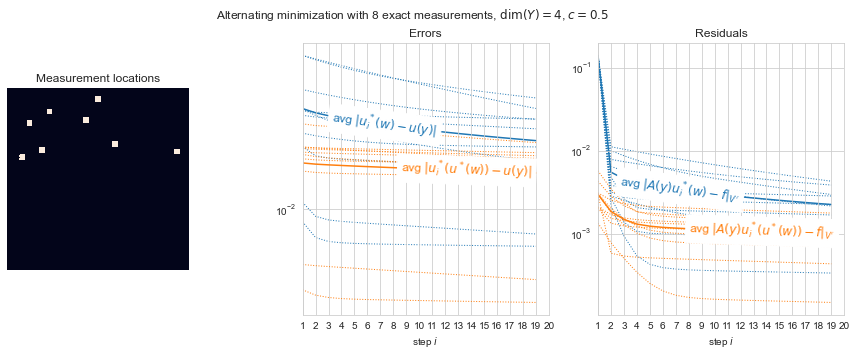

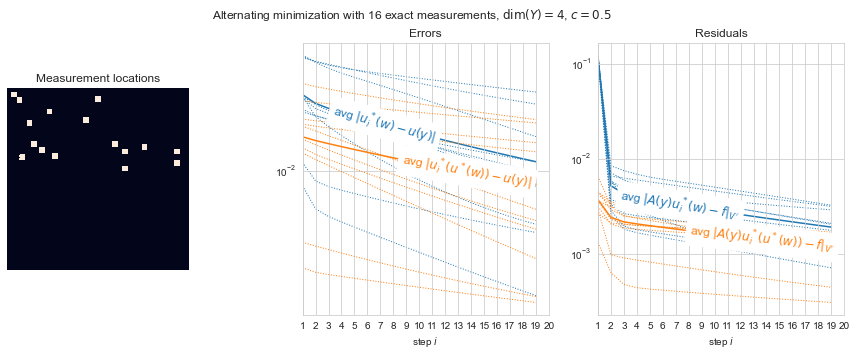

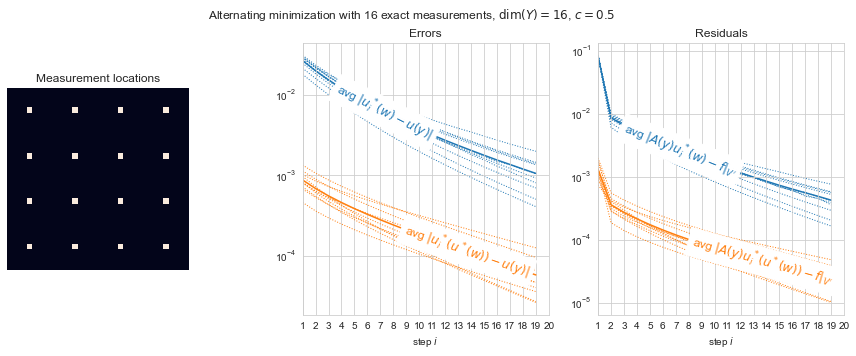

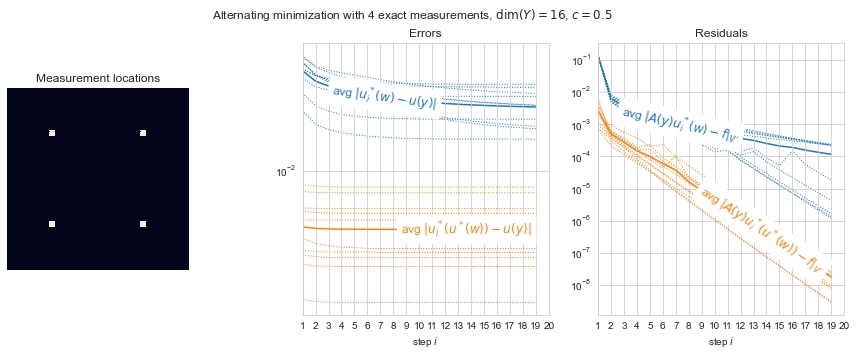

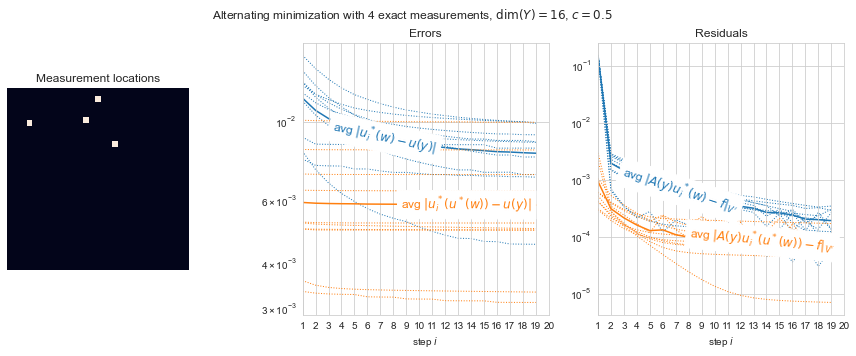

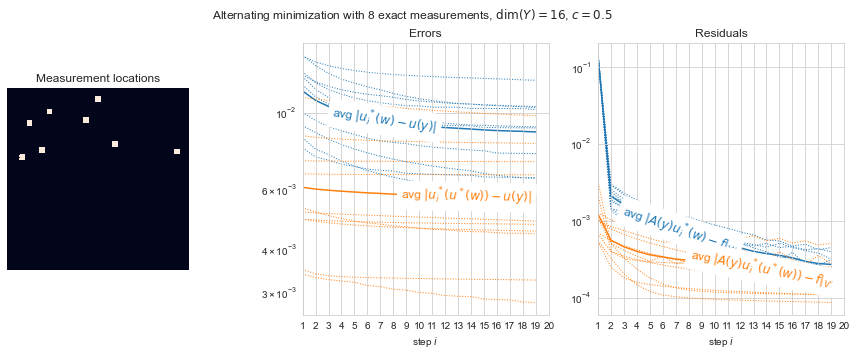

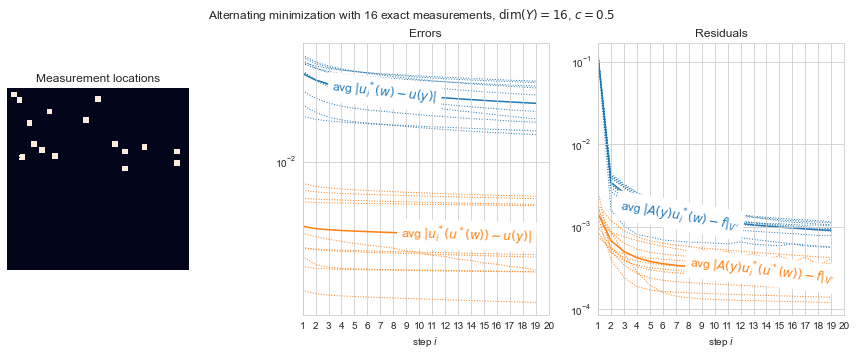

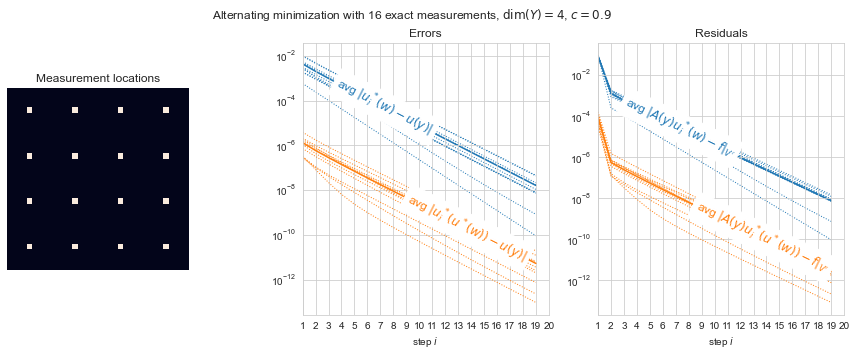

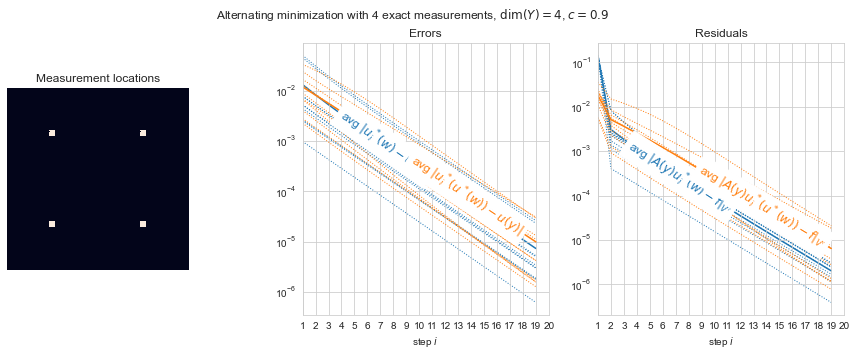

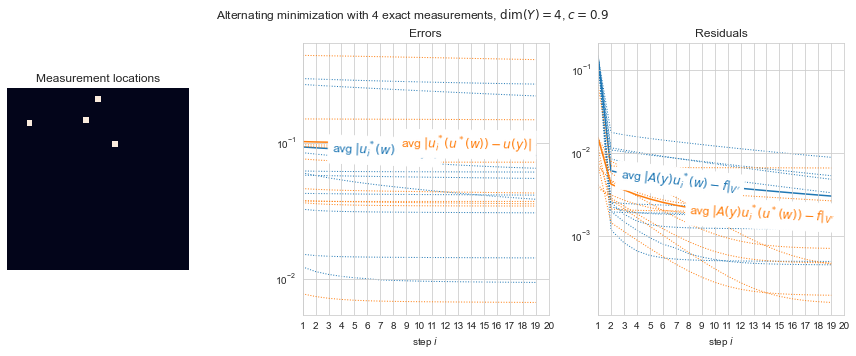

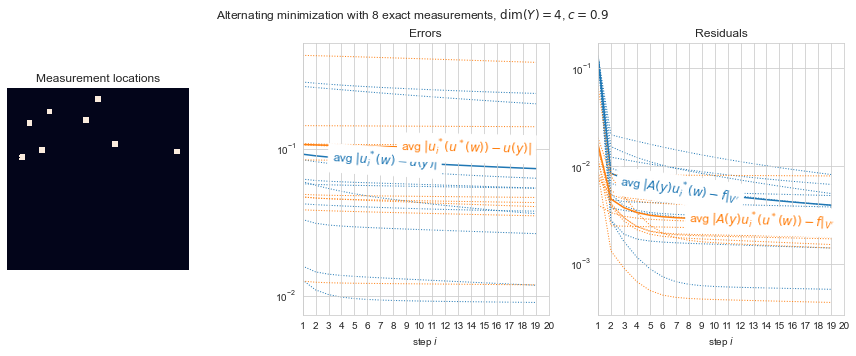

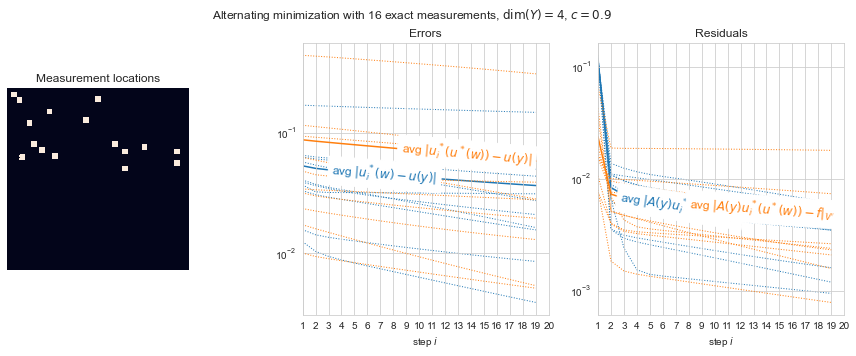

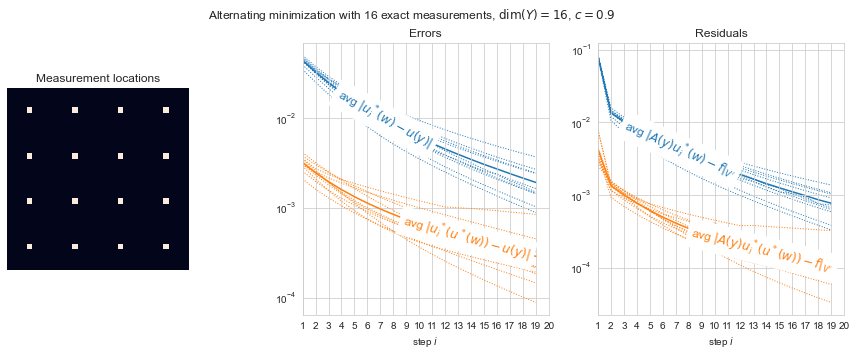

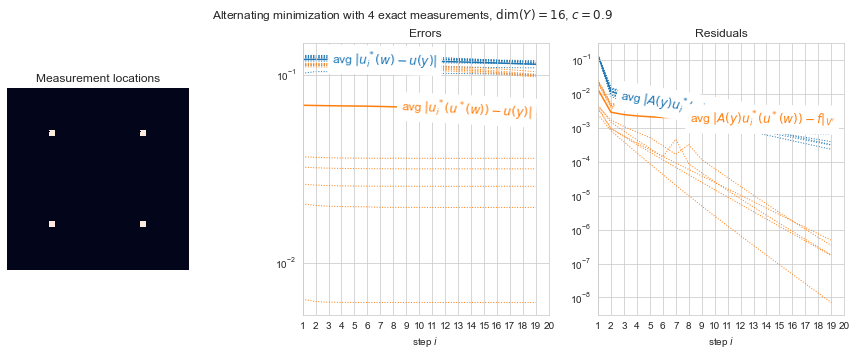

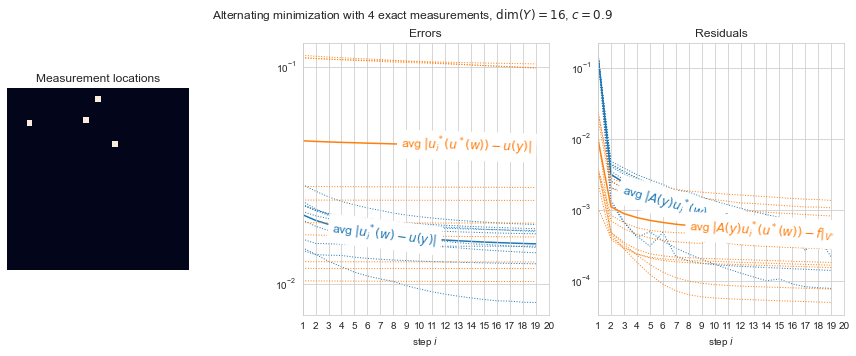

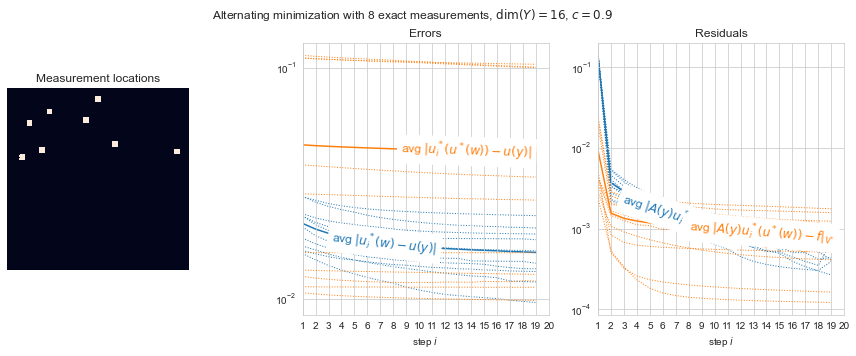

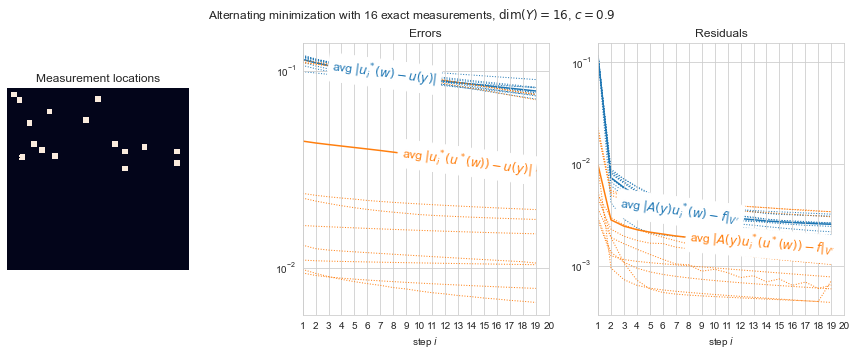

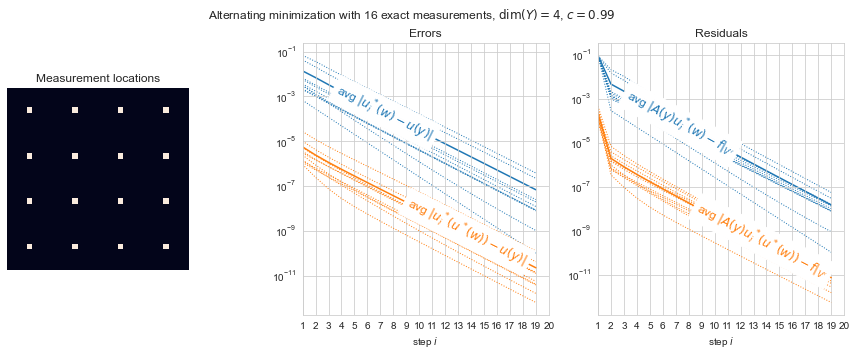

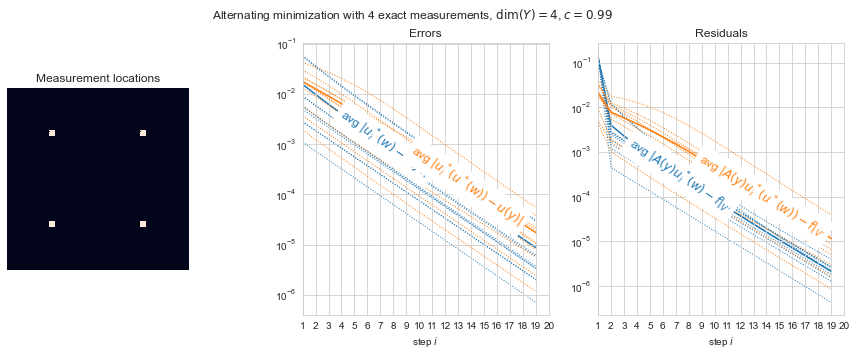

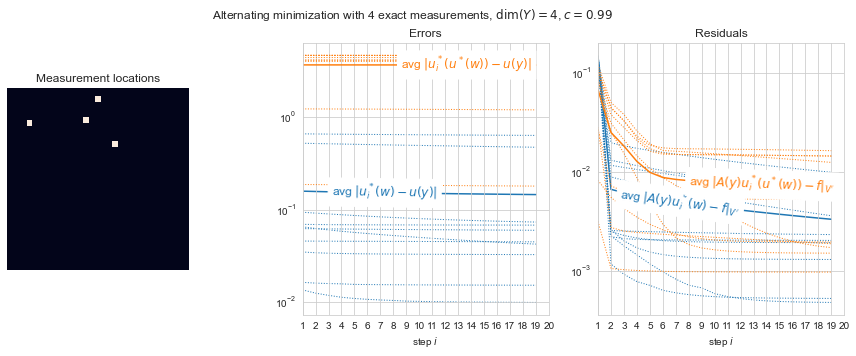

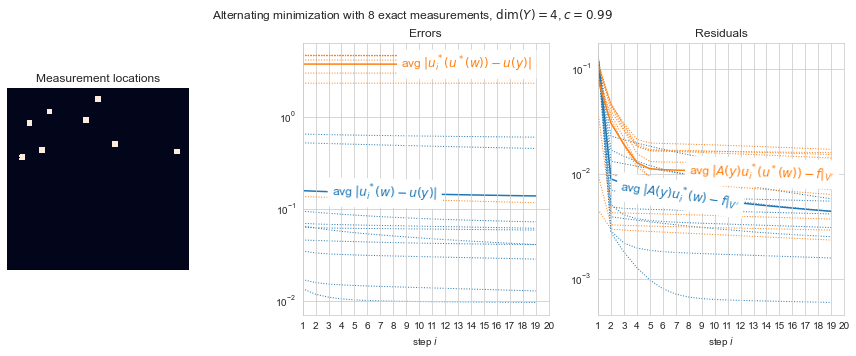

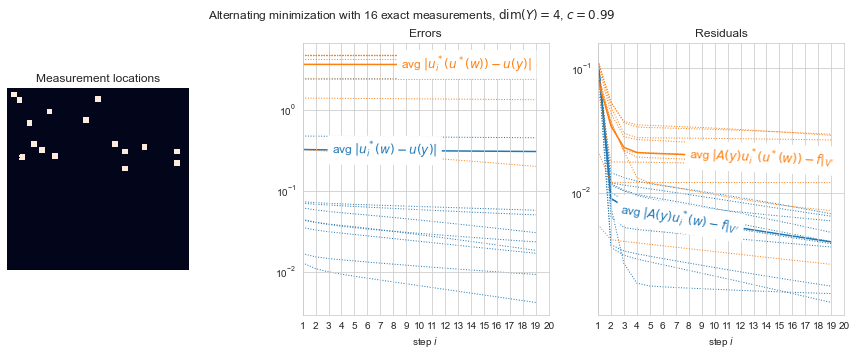

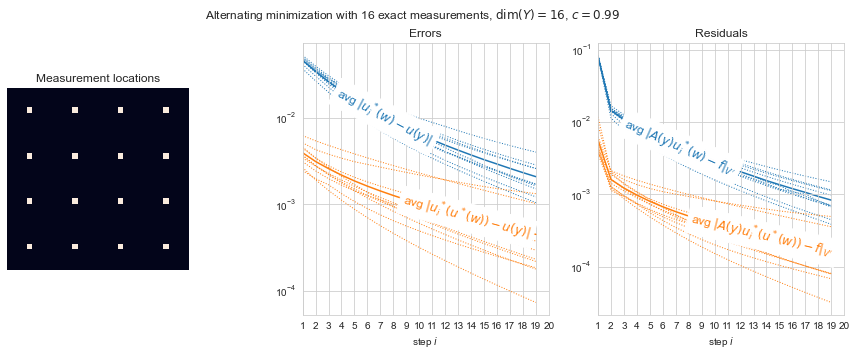

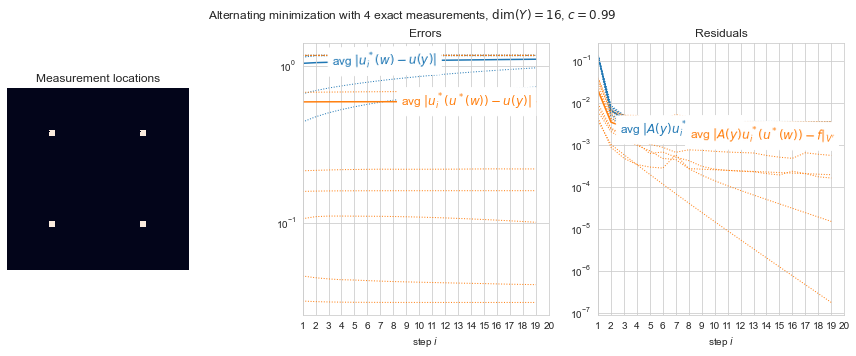

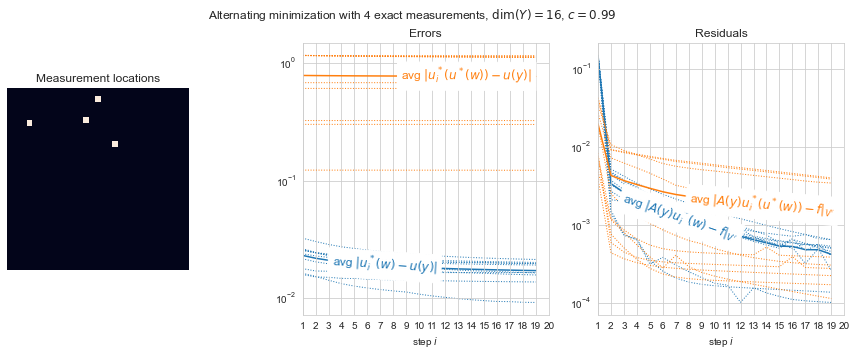

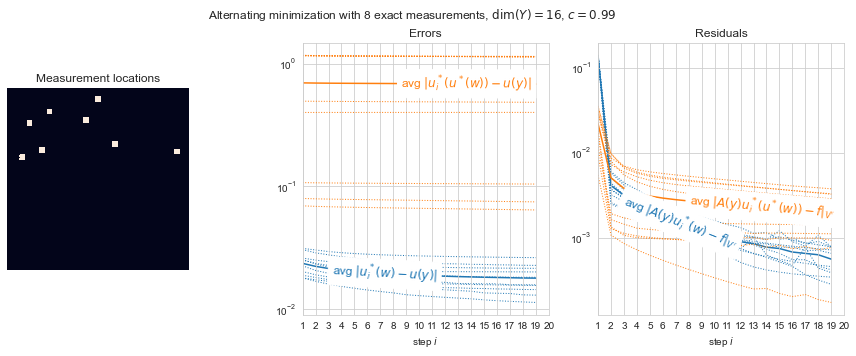

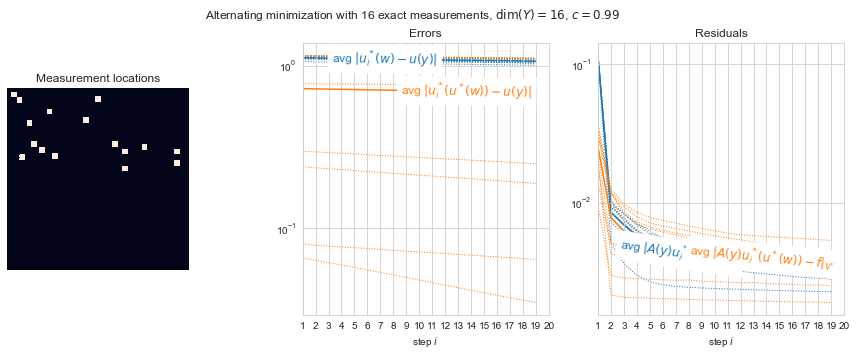

In [16]:
#np.save('./07_alt_min_errs', errs)
#np.save('./07_alt_min_res', res)
#errs = np.load('./07_alt_min_errs.npy')
#res = np.load('./07_alt_min_res.npy')

for i, c in enumerate(cs):
    for j, field_div in enumerate(field_divs):
        side_n = 2**field_div
        d = side_n * side_n
        for k, (Wm, Wm_L2, Wm_loc) in enumerate(zip(Wms, Wms_L2, Wms_loc)):

            fig = plt.figure(figsize=(15, 5))
            ax = fig.add_subplot(1, 4, 1)            
            sns.heatmap(Wm_loc, square=True, cbar=False, xticklabels=False, yticklabels=False)
            ax.set_title(f'Measurement locations')
            ax = fig.add_subplot(1, 3, 2)
            for l in range(N_te):
                plt.semilogy(range(n_steps), errs[0,0,i,j,k,l], ':', lw=1, color=cp[0], zorder=0)
                plt.semilogy(range(n_steps), errs[0,1,i,j,k,l], ':', lw=1, color=cp[1], zorder=1)
            plt.semilogy(range(n_steps), errs[0,0,i,j,k].mean(axis=0), label=rf'avg $\| u^*_{{i}}(w) - u(y) \|$', color=cp[0], zorder=0)
            plt.semilogy(range(n_steps), errs[0,1,i,j,k].mean(axis=0), label=rf'avg $\| u^*_{{i}}(u^*(w)) - u(y) \|$', color=cp[1], zorder=1)
            ax = plt.gca()
            ax.set_xlim((1,n_steps))
            ax.set_xticks(range(1,n_steps+1))
            xmin,xmax = ax.get_xlim()
            labelLines(plt.gca().get_lines(),zorder=10+1, fontsize=12)
            plt.xlabel(rf'step $i$')
            fig.suptitle(rf'Alternating minimization with {Wm.n} exact measurements, $\mathrm{{dim}}(Y)={d}$, $c = {c}$')
            plt.title(rf'Errors') 
            ax = fig.add_subplot(1, 3, 3)
            for l in range(N_te):
                plt.semilogy(range(1,n_steps), res[0,0,i,j,k,l,1:], ':', lw=1, color=cp[0], zorder=0)
                plt.semilogy(range(1,n_steps), res[0,1,i,j,k,l,1:], ':', lw=1, color=cp[1], zorder=1)
            plt.semilogy(range(1,n_steps), res[0,0,i,j,k,:,1:].mean(axis=0), label=rf'avg $\| A(y) u^*_{{i}}(w) - f \|_{{V^\prime}}$', color=cp[0], zorder=0)
            plt.semilogy(range(1,n_steps), res[0,1,i,j,k,:,1:].mean(axis=0), label=rf'avg $\| A(y) u^*_{{i}}(u^*(w)) - f \|_{{V^\prime}}$', color=cp[1], zorder=1)
            plt.xlabel(rf'step $i$')
            plt.title(rf'Residuals')
            ax = plt.gca()
            ax.set_xlim((1,n_steps))
            ax.set_xticks(range(1,n_steps+1))
            xmin,xmax = ax.get_xlim()
            labelLines(plt.gca().get_lines(),zorder=10+1, fontsize=12)
            plt.savefig(f'./figs/alt_min_{d}_{c}_{Wms_name[k]}.pdf')
            plt.show()

# Now we use a nonlinear estimator as the starting point too, and do the dual minimization only in a local cell. In addition to this we assume there is some anisotropy, e.g. $c_\ell = \ell^{-1}$


In [15]:
num_splits = 20
n_steps = 21

# Indexes: 
# 1: Result type, 0 = u_star, 1 = v_star
# 2: Starting point, 0 = w, 1 = u_star, 2 = PW_u_star
# 3: c
# 4: field_div
# 5: Wm choice
# 6: Test point
errs_pw = np.zeros((2,3,len(cs),2,len(Wms),N_te,n_steps))
res_pw = np.zeros((2,3,len(cs),2,len(Wms),N_te,n_steps))
y_err_pw = np.zeros((3,len(cs),2,len(Wms),N_te,n_steps))

idx_combos = [[1,0,0],     # c=0.9 d=4 Wm=reg 4
              [1,0,1],     # c=0.9 d=4 Wm=reg 16
              [1,0,3],     # c=0.9 d=4 Wm=rand 8
              [1,1,0],     # c=0.9 d=16 Wm=reg 4
              [1,1,1],     # c=0.9 d=16 Wm=reg 16
              [1,1,3]]     # c=0.9 d=16 Wm=rand 8
              
#for i, c in enumerate(cs):
#    for j, field_div in enumerate(field_divs):

for (i,j,k) in idx_combos:
    c = cs[i]
    field_div = field_divs[j]
    Wm = Wms[k]
    Wm_L2 = Wms_L2[k]

    L2_coarse = hil.L2DyadicSq(field_div)
    field_conv = 1
    side_n = 2**field_div
    d = side_n * side_n
    y_range = np.zeros((d,2))
    y_range[:,0] = -1.0
    y_range[:,1] = 1.0

    index_spiral = to_spiral(np.arange(1,side_n**2+1).reshape((side_n, side_n)))
    weight = ((1 / index_spiral) ** field_conv).flatten()
    y_range = (y_range.T * weight).T

    def diffusion_pde(points):
        solns, fields = make_soln(points, field_space=L2_coarse, fem_space=H1_fine, a_bar=a_bar, c=c)
        return solns

    np.random.seed(1)
    points_tr = np.random.random((N_tr, d)) * (y_range[:, 1] - y_range[:, 0]) + y_range[:, 0]
    us_tr = diffusion_pde(points_tr)
    points_te = np.random.random((N_te, d)) * (y_range[:, 1] - y_range[:, 0]) + y_range[:, 0]
    us_te = diffusion_pde(points_te)

    u_mid = diffusion_pde(np.zeros((1,d)))[0]
    us_tr_mf = us_tr - u_mid

    y_guesser = hil.DyadicGuesser(field_mean=a_bar, field_mult=c, fem_space=H1_fine, field_space=L2_coarse, y_bounds=y_range)
    U_tr = rm.ParamBasis(us_tr, points_tr)
    U_te = us_te

    #for k, (Wm, Wm_L2) in enumerate(zip(Wms[:2], Wms_L2[:2])):
    Wm_ortho = Wm.orthonormalise()
    m = Wm.n
    print(f'c: {c} d: {d} m: {m}')

    ws_te = Wm.A @ us_te
    ws_te_ortho = Wm_ortho.A @ us_te
    greedy = rm.GreedyApprox(us_tr_mf, verbose=True)

    lwc = rm.ParamDecompTreeWC(U_tr, diffusion_pde, y_range, est_n=Wm_ortho.n, min_N=50, affine=True, Wm=Wm_ortho)
    for i_split in range(1,num_splits+1):
        print(f'Split {i_split}... ')
        lwc.split_leaf(directions='max', choose_big_leaf=True)
        print('(Leaf): dimension | ', end='')
        for j_split, leaf in enumerate(lwc.leaves):
            print(f'({j_split}): {leaf.lin_est.n} ', end='')

    Vn, resids, betas = greedy.construct_to_poor_mans_criteria(Wm)
    lin_est = rm.LinearWorstCaseEstimator(Vn.orthonormalise(), center=u_mid, Wm=Wm_ortho)
    pw_est = lwc.oracle_estimator

    u_stars = lin_est.best_estimate(ws_te_ortho)
    #u_stars_pw, y_guesses, u_guesses, idxs = pw_est.best_resid_estimate(w_te_ortho, y_guesser, diffusion_pde, return_index=True)

    for l in range(N_te):
        u_te = us_te[l]
        y_te = points_te[l]
        w_te = ws_te[:,l]
        w_te_ortho = ws_te_ortho[:,l]
        w = Wm.dot_to_projection(w_te)

        #import pdb; pdb.set_trace()
        u_star_pw, y_guess, u_guess, idx = pw_est.best_resid_estimate(w_te_ortho, y_guesser, diffusion_pde, return_index=True)
        # GET THE Y RANGE AND DO THE GUESSER ON IT
        y_local_range = pw_est._param_ranges[idx]
        y_local_guesser = hil.DyadicGuesser(field_mean=a_bar, field_mult=c, fem_space=H1_fine, field_space=L2_coarse, y_bounds=y_local_range)

        # First we just use w as a starting point
        errs_pw[0,0,i,j,k,l,:], res_pw[0,0,i,j,k,l,:], errs_pw[1,0,i,j,k,l,:], res_pw[1,0,i,j,k,l,:], y_err_pw[0,i,j,k,l,:] = alternate_minimize(w, w_te, Wm, Wm_L2, u_te, y_te, diffusion_pde, y_guesser, n_steps)
        # Now we use u*(w) as a starting point
        errs_pw[0,1,i,j,k,l,:], res_pw[0,1,i,j,k,l,:], errs_pw[1,1,i,j,k,l,:], res_pw[1,1,i,j,k,l,:], y_err_pw[1,i,j,k,l,:] = alternate_minimize(u_stars[l], w_te, Wm, Wm_L2, u_te, y_te, diffusion_pde, y_guesser, n_steps)
        # Now we use u_pw*(w) as a starting point
        errs_pw[0,2,i,j,k,l,:], res_pw[0,2,i,j,k,l,:], errs_pw[1,2,i,j,k,l,:], res_pw[1,2,i,j,k,l,:], y_err_pw[2,i,j,k,l,:] = alternate_minimize(u_star_pw, w_te, Wm, Wm_L2, u_te, y_te, diffusion_pde, y_local_guesser, n_steps)
        
np.save('./07_alt_min_errs_pw', errs_pw)
np.save('./07_alt_min_res_pw', res_pw)
np.save('./07_alt_min_y_pw', y_err_pw)

c: 0.9 d: 4 m: 16
Split 1... 
(Leaf): dimension | (0): 11 (1): 11 Split 2... 
(Leaf): dimension | (0): 11 (1): 11 (2): 11 Split 3... 
(Leaf): dimension | (0): 11 (1): 11 (2): 11 (3): 11 Split 4... 
(Leaf): dimension | (0): 11 (1): 11 (2): 11 (3): 11 (4): 11 Split 5... 
(Leaf): dimension | (0): 11 (1): 11 (2): 11 (3): 11 (4): 11 (5): 11 Split 6... 
(Leaf): dimension | (0): 11 (1): 11 (2): 11 (3): 11 (4): 11 (5): 11 (6): 11 Split 7... 
(Leaf): dimension | (0): 11 (1): 11 (2): 11 (3): 11 (4): 11 (5): 11 (6): 11 (7): 11 Split 8... 
(Leaf): dimension | (0): 11 (1): 11 (2): 11 (3): 11 (4): 11 (5): 11 (6): 11 (7): 11 (8): 11 Split 9... 
(Leaf): dimension | (0): 11 (1): 11 (2): 11 (3): 11 (4): 11 (5): 11 (6): 11 (7): 11 (8): 11 (9): 11 Split 10... 
(Leaf): dimension | (0): 11 (1): 11 (2): 11 (3): 11 (4): 11 (5): 11 (6): 11 (7): 11 (8): 11 (9): 11 (10): 11 Split 11... 
(Leaf): dimension | (0): 11 (1): 11 (2): 11 (3): 11 (4): 11 (5): 11 (6): 11 (7): 11 (8): 11 (9): 11 (10): 11 (11): 11 Split 12.

1 : 	 727 	 0.4275144689136415
2 : 	 991 		 0.09121162021116958
3 : 	 354 		 0.056323547840862034
4 : 	 573 		 0.04902294764987495
5 : 	 343 		 0.0405172821875823
6 : 	 402 		 0.020202449813760903
7 : 	 1496 		 0.013720775256440682
8 : 	 990 		 0.009988931465641901
9 : 	 430 		 0.005822340802254181
Done!
minimum of residual * stability at dimension 1: 938.0320256623022
c: 0.9 d: 16 m: 16
Split 1... 
(Leaf): dimension | (0): 9 (1): 16 Split 2... 
(Leaf): dimension | (0): 11 (1): 16 (2): 16 Split 3... 
(Leaf): dimension | (0): 13 (1): 16 (2): 16 (3): 16 Split 4... 
(Leaf): dimension | (0): 16 (1): 16 (2): 16 (3): 16 (4): 16 Split 5... 
(Leaf): dimension | (0): 16 (1): 16 (2): 16 (3): 16 (4): 16 (5): 16 Split 6... 
(Leaf): dimension | (0): 16 (1): 16 (2): 16 (3): 16 (4): 16 (5): 16 (6): 16 Split 7... 
(Leaf): dimension | (0): 16 (1): 16 (2): 16 (3): 16 (4): 16 (5): 16 (6): 16 (7): 16 Split 8... 
(Leaf): dimension | (0): 16 (1): 16 (2): 16 (3): 16 (4): 16 (5): 16 (6): 16 (7): 16 (8): 16 Sp

(Leaf): dimension | (0): 1 (1): 1 (2): 1 (3): 2 (4): 2 (5): 1 (6): 5 (7): 1 (8): 1 (9): 2 (10): 3 (11): 1 (12): 1 (13): 1 (14): 3 (15): 3 (16): 3 (17): 4 (18): 2 (19): 1 Split 20... 
(Leaf): dimension | (0): 1 (1): 1 (2): 1 (3): 2 (4): 2 (5): 1 (6): 5 (7): 1 (8): 1 (9): 2 (10): 3 (11): 1 (12): 1 (13): 1 (14): 3 (15): 3 (16): 3 (17): 4 (18): 2 (19): 4 (20): 1 Greedy construction to "poor man's" criteria
i 	 Selection 	 Sel. criteria
1 : 	 318 	 0.11043642549679326
2 : 	 310 		 0.024815450257375273
3 : 	 1560 		 0.01887547554614204
4 : 	 1316 		 0.016553108672624016
5 : 	 1151 		 0.014234332272601496
6 : 	 1210 		 0.01367688095169113
7 : 	 1132 		 0.012623781220508086
8 : 	 1973 		 0.011047624902510175
9 : 	 361 		 0.009420759538243926
Done!
minimum of residual * stability at dimension 1: 415.43084650402795


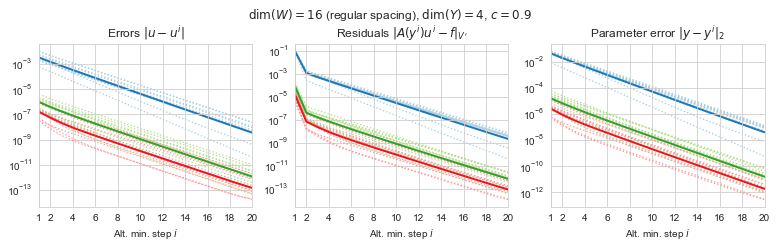

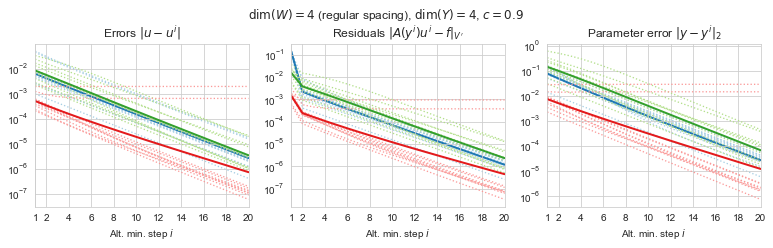

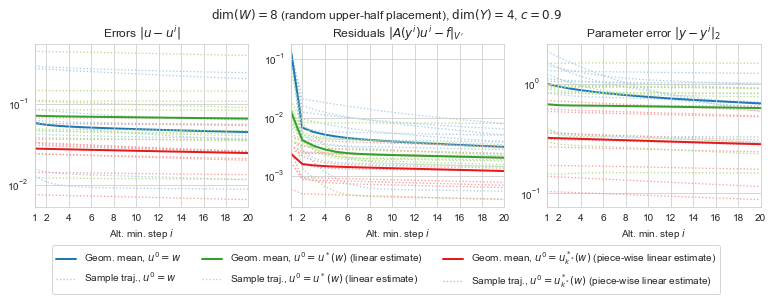

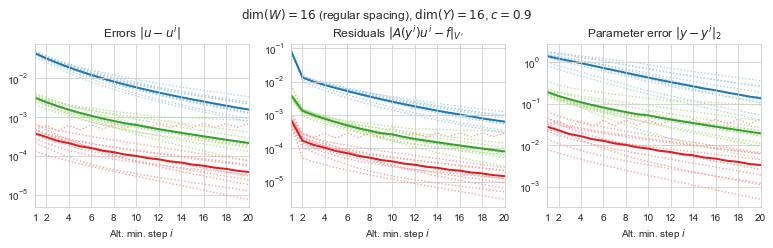

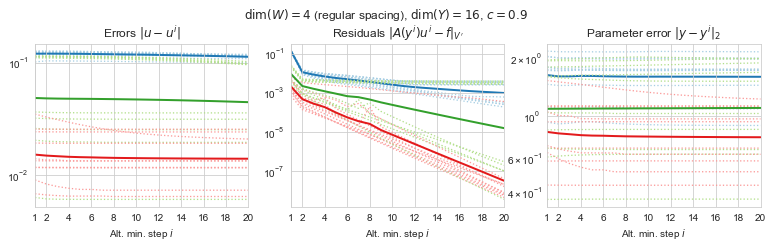

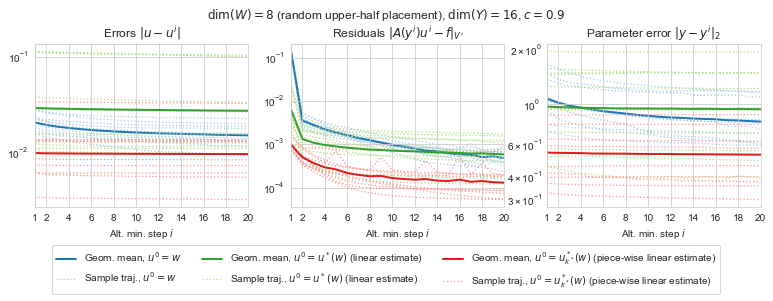

In [16]:
errs_pw = np.load('./07_alt_min_errs_pw.npy')
res_pw = np.load('./07_alt_min_res_pw.npy')
y_err_pw = np.load('./07_alt_min_y_pw.npy')
cp = sns.color_palette("Paired")

N_tr = 2000
N_te = 10
cs = [0.5, 0.9, 0.99]
field_divs = [1,2]
spacings = [5, 6]
idx_combos = [[1,0,0],     # c=0.9 d=4 Wm=reg 4
              [1,0,1],     # c=0.9 d=4 Wm=reg 16
              [1,0,3],     # c=0.9 d=4 Wm=rand 8
              [1,1,0],     # c=0.9 d=16 Wm=reg 4
              [1,1,1],     # c=0.9 d=16 Wm=reg 16
              [1,1,3]]     # c=0.9 d=16 Wm=rand 8

Wm_loc_labels = [r'regular spacing', 'regular spacing', 'random upper-half placement', 'random upper-half placement']
Wm_idx = [0, 1, 3, 2]
for idx, (i,j,k) in enumerate(idx_combos):
    
    c = cs[i]
    field_div = field_divs[j]
    Wm = Wms[k]
    Wm_L2 = Wms_L2[k]
    Wm_loc = Wms_loc[k]
    
    s_lw = 1.3
    m_lw = 2

    side_n = 2**field_div
    d = side_n * side_n
    

    #fig = ax.figure(figsize=(15, 12))
    fig, axs = plt.subplots(ncols=3, nrows=1, sharex=True, figsize=(13, 3))
    fig.suptitle(rf'$\mathrm{{dim}}(W)={Wm.n}$ ({Wm_loc_labels[k]}), $\mathrm{{dim}}(Y)={d}$, $c = {c}$', y=1.05, fontsize=12)

    ax = axs[0]
    for l in range(N_te):
        if k == 3 and l ==0:
            ax.semilogy(range(n_steps), errs_pw[0,0,i,j,k,l], ':', label=rf'Sample traj., $u^0 = w$', lw=s_lw, color=cp[0], zorder=0)
            ax.semilogy(range(n_steps), errs_pw[0,1,i,j,k,l], ':', label=rf'Sample traj., $u^0 = u^*(w)$ (linear estimate)', lw=s_lw, color=cp[2], zorder=1)
            ax.semilogy(range(n_steps), errs_pw[0,2,i,j,k,l], ':', label=rf'Sample traj., $u^0 = u^*_{{k^*}}(w)$ (piece-wise linear estimate)', lw=s_lw, color=cp[4], zorder=1)
        else:
            ax.semilogy(range(n_steps), errs_pw[0,0,i,j,k,l], ':', lw=s_lw, color=cp[0], zorder=0)
            ax.semilogy(range(n_steps), errs_pw[0,1,i,j,k,l], ':', lw=s_lw, color=cp[2], zorder=1)
            ax.semilogy(range(n_steps), errs_pw[0,2,i,j,k,l], ':', lw=s_lw, color=cp[4], zorder=1)
    if k==3:
        ax.semilogy(range(n_steps), np.exp(np.log(errs_pw[0,0,i,j,k]).mean(axis=0)), label=rf'Geom. mean, $u^0 = w$', lw=m_lw, color=cp[1], zorder=0)
        ax.semilogy(range(n_steps), np.exp(np.log(errs_pw[0,1,i,j,k]).mean(axis=0)), label=rf'Geom. mean, $u^0 = u^*(w)$ (linear estimate)', lw=m_lw, color=cp[3], zorder=1)
        ax.semilogy(range(n_steps), np.exp(np.log(errs_pw[0,2,i,j,k]).mean(axis=0)), label=rf'Geom. mean, $u^0 = u^*_{{k^*}}(w)$ (piece-wise linear estimate)', lw=m_lw, color=cp[5], zorder=1)                
    else:
        ax.semilogy(range(n_steps), np.exp(np.log(errs_pw[0,0,i,j,k]).mean(axis=0)), lw=m_lw, color=cp[1], zorder=0)
        ax.semilogy(range(n_steps), np.exp(np.log(errs_pw[0,1,i,j,k]).mean(axis=0)), lw=m_lw, color=cp[3], zorder=1)
        ax.semilogy(range(n_steps), np.exp(np.log(errs_pw[0,2,i,j,k]).mean(axis=0)), lw=m_lw, color=cp[5], zorder=1)                

    ax.set_xlim((1, n_steps-1))
    ax.set_xticks([1,] + list(range(2,n_steps,2)))
    ax.set_xlabel(rf'Alt. min. step $i$')
    ax.set_title(r'Errors $\| u - u^i \|$')     
    
    ax = axs[1]
    for l in range(N_te):
        ax.semilogy(range(1,n_steps), res_pw[0,0,i,j,k,l,1:], ':', lw=s_lw, color=cp[0], zorder=0)
        ax.semilogy(range(1,n_steps), res_pw[0,1,i,j,k,l,1:], ':', lw=s_lw, color=cp[2], zorder=1)
        ax.semilogy(range(1,n_steps), res_pw[0,2,i,j,k,l,1:], ':', lw=s_lw, color=cp[4], zorder=1)
    ax.semilogy(range(1,n_steps), np.exp(np.log(res_pw[0,0,i,j,k,:,1:]).mean(axis=0)), lw=m_lw, color=cp[1], zorder=0)
    ax.semilogy(range(1,n_steps), np.exp(np.log(res_pw[0,1,i,j,k,:,1:]).mean(axis=0)), lw=m_lw, color=cp[3], zorder=1)
    ax.semilogy(range(1,n_steps), np.exp(np.log(res_pw[0,2,i,j,k,:,1:]).mean(axis=0)), lw=m_lw, color=cp[5], zorder=1)
    ax.set_xlabel(rf'Alt. min. step $i$')
    ax.set_title(r'Residuals $\| A(y^i) u^i - f \|_{V^\prime}$')
    ax.set_xlim((1,n_steps-1))
    ax.set_xticks([1,] + list(range(2,n_steps,2)))
    
    ax = axs[2]
    for l in range(N_te):
        ax.semilogy(range(1,n_steps), y_err_pw[0,i,j,k,l,1:], ':', lw=s_lw, color=cp[0], zorder=0)
        ax.semilogy(range(1,n_steps), y_err_pw[1,i,j,k,l,1:], ':', lw=s_lw, color=cp[2], zorder=1)
        ax.semilogy(range(1,n_steps), y_err_pw[2,i,j,k,l,1:], ':', lw=s_lw, color=cp[4], zorder=1)
    ax.semilogy(range(1,n_steps), np.exp(np.log(y_err_pw[0,i,j,k,:,1:]).mean(axis=0)), lw=m_lw, color=cp[1], zorder=0)
    ax.semilogy(range(1,n_steps), np.exp(np.log(y_err_pw[1,i,j,k,:,1:]).mean(axis=0)), lw=m_lw, color=cp[3], zorder=1)
    ax.semilogy(range(1,n_steps), np.exp(np.log(y_err_pw[2,i,j,k,:,1:]).mean(axis=0)), lw=m_lw, color=cp[5], zorder=1)                
    ax.set_xlim((1,n_steps-1))
    ax.set_xticks([1,] + list(range(2,n_steps,2)))
    ax.set_title(r'Parameter error $\| y - y^i \|_2$')
    ax.set_xlabel(rf'Alt. min. step $i$')
        
    if k==3:
        handles, labels = axs[0].get_legend_handles_labels()
        handles = [handles[3], handles[0], handles[4], handles[1], handles[5], handles[2]]
        labels = [labels[3], labels[0], labels[4], labels[1], labels[5], labels[2]]
        fig.legend(handles, labels, loc='lower center', fancybox=True, ncol=3, bbox_to_anchor=(0.5, -0.3))#, fancybox=True, shadow=True, ncol=5)

    plt.savefig(f'./figs/alt_min_pw_est_{d}_{c}_{Wms_name[k]}.pdf', bbox_inches='tight')
    plt.show()